**Link Dataset** : https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis

## Import Library

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime, timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import h5py
import itertools
import networkx as nx
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Data Loading

In [2]:
# Load data
df = pd.read_excel('dataset/Assignment-1_Data.xlsx')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Exploratory Data Analysis (EDA)

In [3]:
# Cek informasi umum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      522064 non-null  object        
 1   Itemname    520609 non-null  object        
 2   Quantity    522064 non-null  int64         
 3   Date        522064 non-null  datetime64[ns]
 4   Price       522064 non-null  float64       
 5   CustomerID  388023 non-null  float64       
 6   Country     522064 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 27.9+ MB


In [4]:
# Statistik deskriptif
df.describe()

,Quantity,Date,Price,CustomerID
count,522064.000000,522064,522064.000000,388023.000000
mean,10.090435,2011-07-04 12:51:20.777107456,3.826801,15316.931710
min,-9600.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 10:15:00,1.250000,13950.000000
50%,3.000000,2011-07-20 08:59:00,2.080000,15265.000000
75%,10.000000,2011-10-19 14:12:00,4.130000,16837.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,161.110525,NaN,41.900599,1721.846964


In [5]:
# Cek missing values
df.isnull().sum()

BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64

In [6]:
# Cek jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_count}")

Jumlah baris duplikat: 5286


In [7]:
# Identifikasi Kolom Numerik dan Kategorikal
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nKolom Numerik: {num_cols}")
print(f"Kolom Kategorikal: {cat_cols}")


Kolom Numerik: ['Quantity', 'Price', 'CustomerID']
Kolom Kategorikal: ['BillNo', 'Itemname', 'Country']


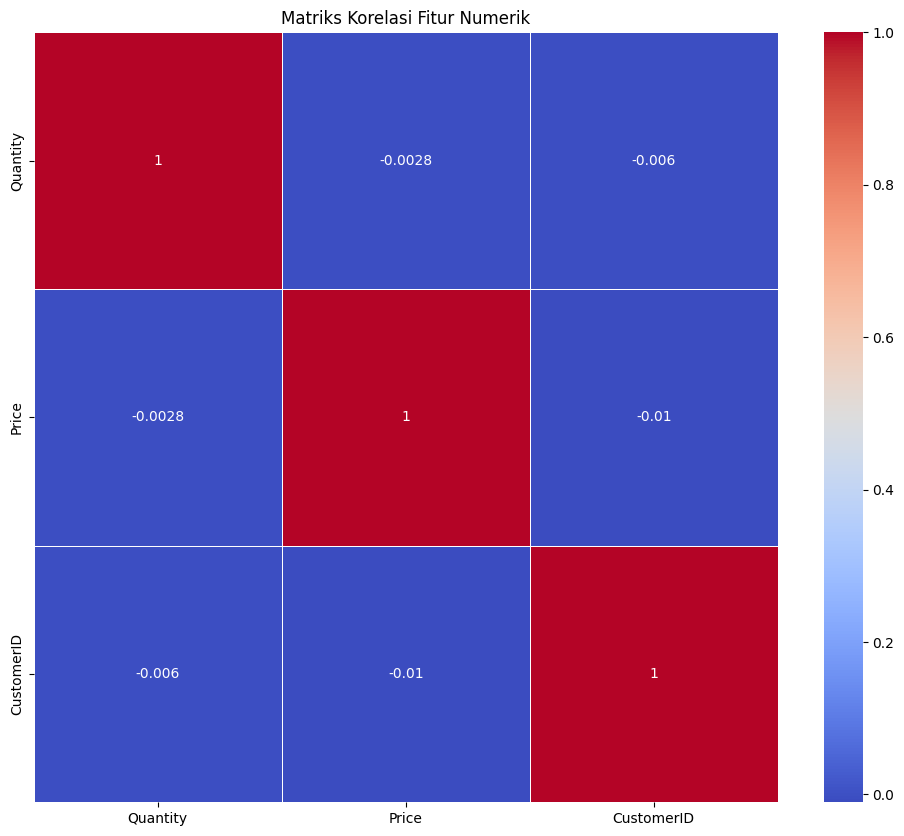

In [8]:
# Analisis Korelasi untuk Fitur Numerik
if len(num_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[num_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriks Korelasi Fitur Numerik')
    plt.show()

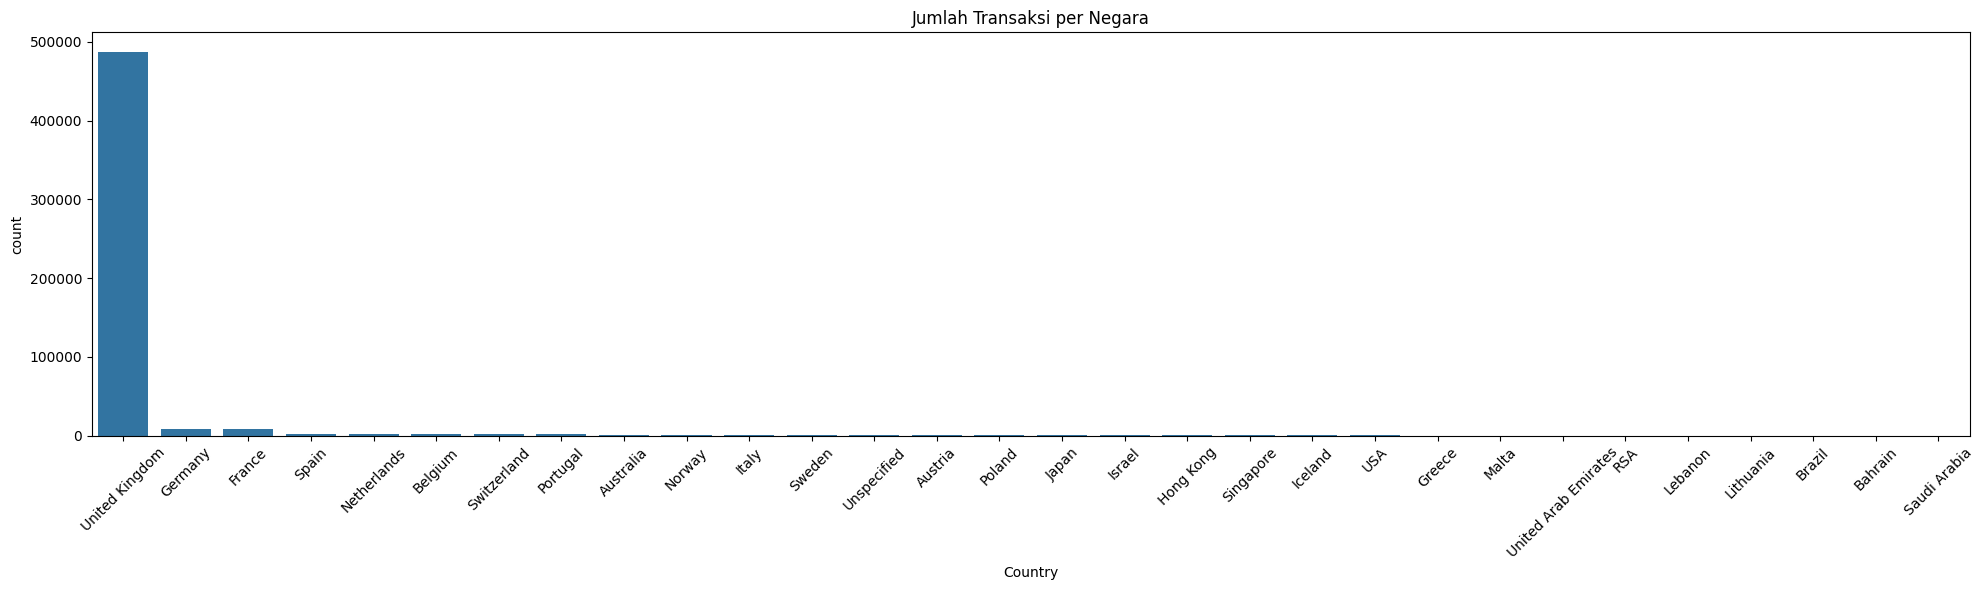

In [9]:
# Distribusi Transaksi per Negara
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='Country', order=df['Country'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Jumlah Transaksi per Negara')
plt.tight_layout()
plt.show()

In [10]:
# Atur supaya pandas tampilkan semua baris output
pd.set_option('display.max_rows', None)

print(df['Itemname'].value_counts())


Itemname
WHITE HANGING HEART T-LIGHT HOLDER      2269
JUMBO BAG RED RETROSPOT                 2087
REGENCY CAKESTAND 3 TIER                1930
PARTY BUNTING                           1677
LUNCH BAG RED RETROSPOT                 1570
ASSORTED COLOUR BIRD ORNAMENT           1465
SET OF 3 CAKE TINS PANTRY DESIGN        1360
PACK OF 72 RETROSPOT CAKE CASES         1328
LUNCH BAG  BLACK SKULL.                 1315
NATURAL SLATE HEART CHALKBOARD          1246
JUMBO BAG PINK POLKADOT                 1231
HEART OF WICKER SMALL                   1206
JUMBO STORAGE BAG SUKI                  1191
PAPER CHAIN KIT 50'S CHRISTMAS          1183
JUMBO SHOPPER VINTAGE RED PAISLEY       1181
LUNCH BAG SPACEBOY DESIGN               1169
LUNCH BAG CARS BLUE                     1156
SPOTTY BUNTING                          1133
JAM MAKING SET PRINTED                  1123
LUNCH BAG SUKI DESIGN                   1112
WOODEN PICTURE FRAME WHITE FINISH       1103
RECIPE BOX PANTRY YELLOW DESIGN         1101
L

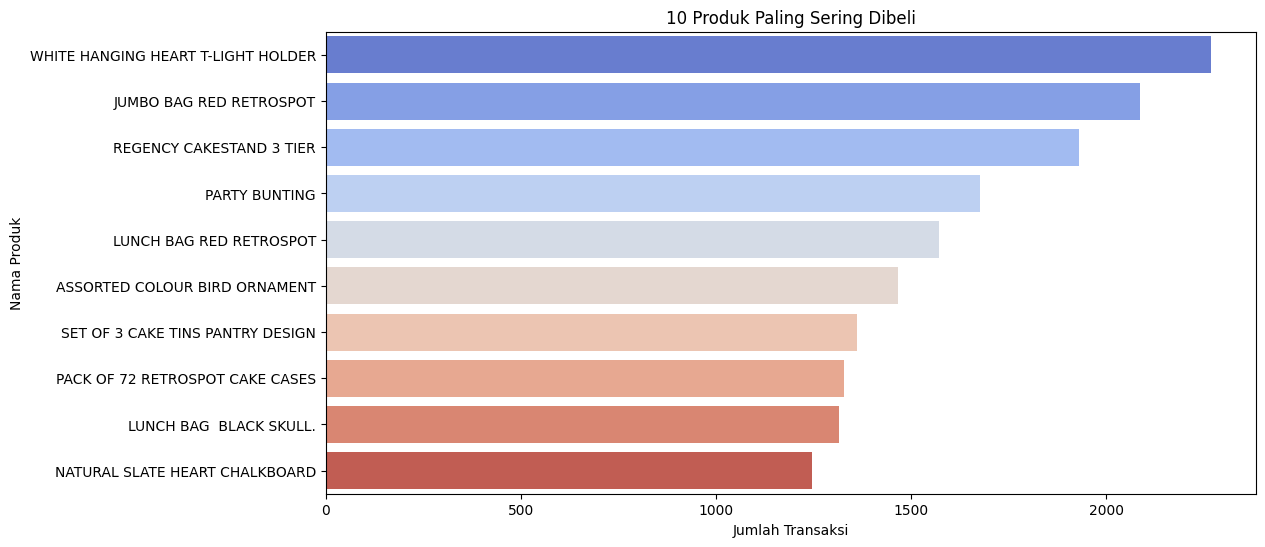

In [10]:
# 10 Produk Terpopuler
top_items = df['Itemname'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_items.values, y=top_items.index, palette='coolwarm')
plt.title('10 Produk Paling Sering Dibeli')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Nama Produk')
plt.show()

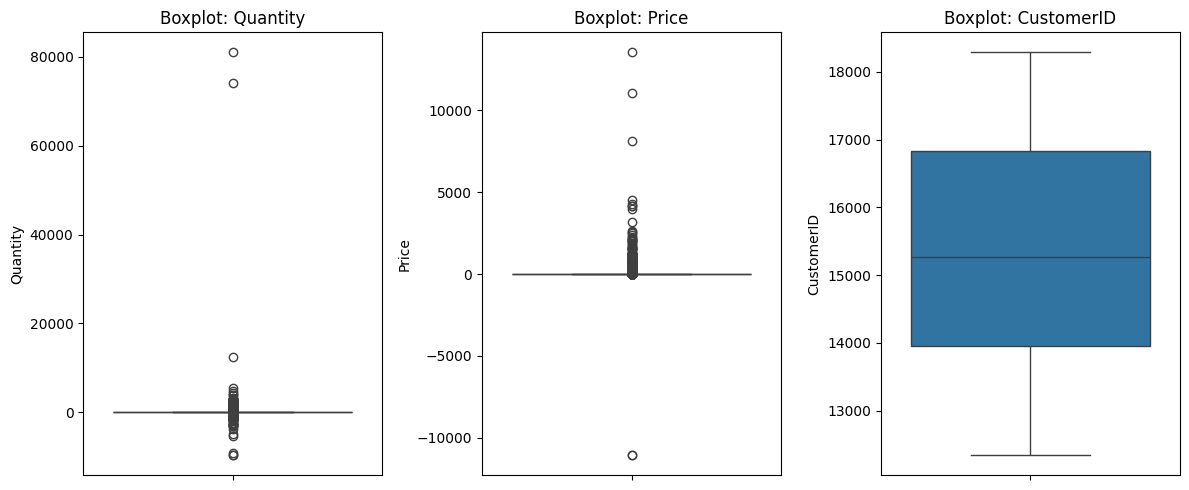

In [11]:
# Deteksi Outlier
plt.figure(figsize=(12, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

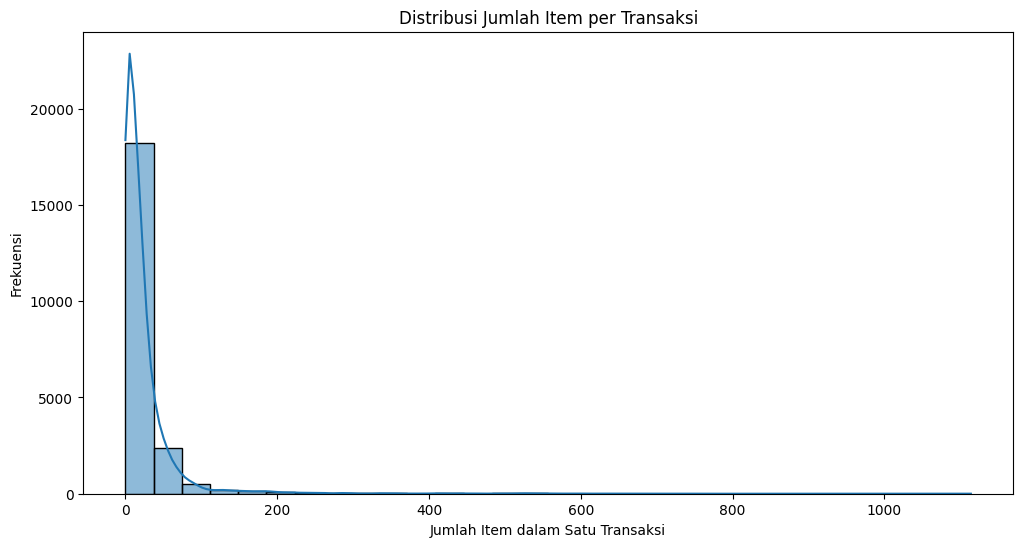

In [12]:
# Distribusi Jumlah Item dalam Transaksi
items_per_invoice = df.groupby('BillNo')['Itemname'].count()

plt.figure(figsize=(12, 6))
sns.histplot(items_per_invoice, bins=30, kde=True)
plt.title('Distribusi Jumlah Item per Transaksi')
plt.xlabel('Jumlah Item dalam Satu Transaksi')
plt.ylabel('Frekuensi')
plt.show()

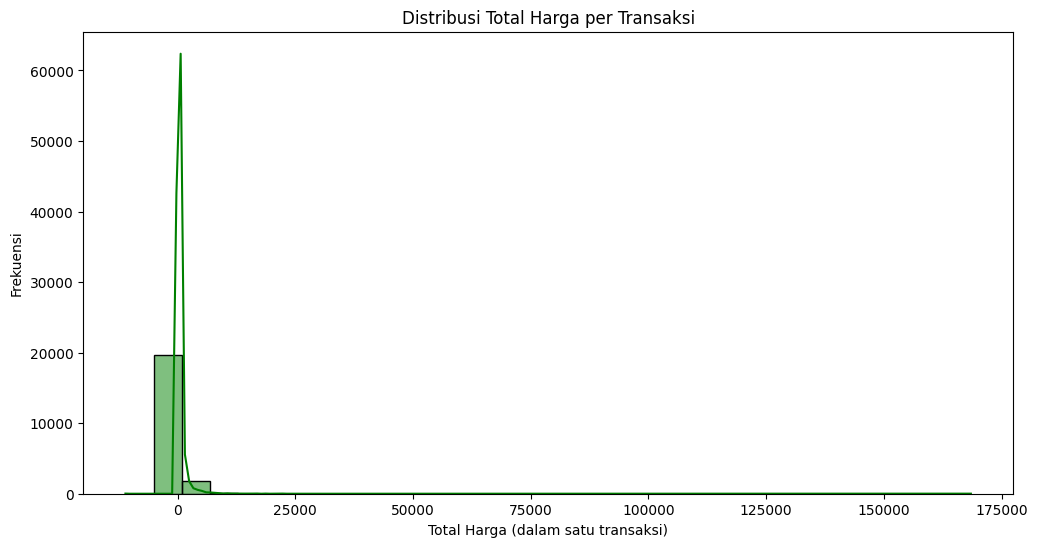

In [13]:
# Total Harga per Transaksi
df['TotalPrice'] = df['Quantity'] * df['Price']
revenue_per_invoice = df.groupby('BillNo')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
sns.histplot(revenue_per_invoice, bins=30, kde=True, color='green')
plt.title('Distribusi Total Harga per Transaksi')
plt.xlabel('Total Harga (dalam satu transaksi)')
plt.ylabel('Frekuensi')
plt.show()

### Data Preprocessing

In [14]:
# 1. Mengcopy dataframe untuk keamanan
data = df.copy()

In [15]:
# 2. Menghapus kolom
data = data.drop(columns=['CustomerID', 'Price', 'Quantity', 'Country', 'Date', 'TotalPrice'])

In [16]:
# 3. Menangani Missing value
data.dropna(inplace=True)
print("\nJumlah missing values Akhir")
print(data.isnull().sum())


Jumlah missing values Akhir
BillNo      0
Itemname    0
dtype: int64


In [17]:
# 4.Menghapus data duplikat
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

0


In [18]:
# 7. Standardisasi nama produk  
data['Itemname'] = data['Itemname'].str.strip().str.upper()
print("Jumlah produk unik: {data['Itemname'].nunique()}")

Jumlah produk unik: {data['Itemname'].nunique()}


In [19]:
# 8. Filter produk dengan frekuensi minimum
min_frequency = 5
product_counts = data['Itemname'].value_counts()
valid_products = product_counts[product_counts >= min_frequency].index
data = data[data['Itemname'].isin(valid_products)]

print(f"Data setelah filter produk (min {min_frequency} kemunculan): {len(data)}")
print(f"Produk unik tersisa: {data['Itemname'].nunique()}")

Data setelah filter produk (min 5 kemunculan): 508573
Produk unik tersisa: 3529


In [20]:
# 9. Filter transaksi dengan item maksimal 50 (hapus bulk order)
transaction_sizes = data.groupby('BillNo').size()
valid_transactions = transaction_sizes[transaction_sizes <= 50].index
data = data[data['BillNo'].isin(valid_transactions)]

print(f"Data setelah filter transaksi outlier: {len(data)}")
print(f"Jumlah transaksi: {data['BillNo'].nunique()}")

Data setelah filter transaksi outlier: 274685
Jumlah transaksi: 17962


In [21]:
# Create pivot table (basket format)
pivot_table = pd.crosstab(data['BillNo'], data['Itemname'])
pivot_table = (pivot_table > 0).astype(int)

print(f"Pivot table shape: {pivot_table.shape}")
print(f"Sample pivot table:\n{pivot_table.head()}")

Pivot table shape: (17962, 3460)
Sample pivot table:
Itemname  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
BillNo                                                         
536365                         0                           0   
536366                         0                           0   
536367                         0                           0   
536368                         0                           0   
536369                         0                           0   

Itemname  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
BillNo                                                           
536365                            0                          0   
536366                            0                          0   
536367                            0                          0   
536368                            0                          0   
536369                            0                          0   

Itemname  12 HANGING EGGS HAND PAIN

In [29]:
# Generate frequent itemsets
print("Generating frequent itemsets...")
frequent_itemsets = apriori(pivot_table, min_support=0.015, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Frequent itemsets found: {len(frequent_itemsets)}")
print("\nTop 10 frequent itemsets:")
print(frequent_itemsets.head(10))

Generating frequent itemsets...
Frequent itemsets found: 243

Top 10 frequent itemsets:
    support                           itemsets  length
0  0.015254         (3 STRIPEY MICE FELTCRAFT)       1
1  0.028727           (6 RIBBONS RUSTIC CHARM)       1
2  0.017927  (60 CAKE CASES VINTAGE CHRISTMAS)       1
3  0.022937      (60 TEATIME FAIRY CAKE CASES)       1
4  0.016646   (72 SWEETHEART FAIRY CAKE CASES)       1
5  0.034517       (ALARM CLOCK BAKELIKE GREEN)       1
6  0.019987       (ALARM CLOCK BAKELIKE IVORY)       1
7  0.015254      (ALARM CLOCK BAKELIKE ORANGE)       1
8  0.024775        (ALARM CLOCK BAKELIKE PINK)       1
9  0.037691         (ALARM CLOCK BAKELIKE RED)       1


In [30]:
# Generate association rules
print("Generating association rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

print(f"Association rules found: {len(rules)}")
print("\nRules statistics:")
print(rules[['support', 'confidence', 'lift']].describe())

# Sort rules by confidence and lift
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

Generating association rules...
Association rules found: 69

Rules statistics:
         support  confidence       lift
count  69.000000   69.000000  69.000000
mean    0.017982    0.478385  12.850274
std     0.002782    0.163742   7.228819
min     0.015199    0.203798   4.066441
25%     0.016145    0.358974   7.886372
50%     0.016980    0.461187   9.677802
75%     0.019096    0.599705  17.374022
max     0.028059    0.907186  29.202273


In [31]:
# Cross-selling recommendations (1 item -> 1 item)
cross_selling_rules = rules[
    (rules['antecedents'].apply(len) == 1) & 
    (rules['consequents'].apply(len) == 1)
].sort_values(by=['confidence', 'support'], ascending=False)

# Get top recommendations
top_cross_selling = cross_selling_rules.head(10)

print("=" * 50)
print("REKOMENDASI CROSS-SELLING (Top 10):")
print("=" * 50)
for idx, row in top_cross_selling.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    confidence = row['confidence']
    support = row['support']
    lift = row['lift']
    print(f"'{antecedent}' -> '{consequent}' (Confidence: {confidence:.3f}, Support: {support:.3f}, Lift: {lift:.3f})")

REKOMENDASI CROSS-SELLING (Top 10):
'PINK REGENCY TEACUP AND SAUCER' -> 'GREEN REGENCY TEACUP AND SAUCER' (Confidence: 0.810, Support: 0.020, Lift: 26.069)
'GREEN REGENCY TEACUP AND SAUCER' -> 'ROSES REGENCY TEACUP AND SAUCER' (Confidence: 0.754, Support: 0.023, Lift: 21.614)
'PINK REGENCY TEACUP AND SAUCER' -> 'ROSES REGENCY TEACUP AND SAUCER' (Confidence: 0.747, Support: 0.019, Lift: 21.406)
'GARDENERS KNEELING PAD CUP OF TEA' -> 'GARDENERS KNEELING PAD KEEP CALM' (Confidence: 0.701, Support: 0.017, Lift: 23.366)
'ROSES REGENCY TEACUP AND SAUCER' -> 'GREEN REGENCY TEACUP AND SAUCER' (Confidence: 0.671, Support: 0.023, Lift: 21.614)
'ALARM CLOCK BAKELIKE GREEN' -> 'ALARM CLOCK BAKELIKE RED' (Confidence: 0.655, Support: 0.023, Lift: 17.374)
'GREEN REGENCY TEACUP AND SAUCER' -> 'PINK REGENCY TEACUP AND SAUCER' (Confidence: 0.649, Support: 0.020, Lift: 26.069)
'DOLLY GIRL LUNCH BOX' -> 'SPACEBOY LUNCH BOX' (Confidence: 0.647, Support: 0.016, Lift: 22.380)
'JUMBO BAG PINK POLKADOT' -> 'JU

In [32]:
# Upselling recommendations (1 item -> multiple items)
upselling_rules = rules[
    (rules['antecedents'].apply(len) == 1) & 
    (rules['consequents'].apply(len) > 1)
].sort_values(by=['confidence', 'support'], ascending=False)

# Get top recommendations
top_upselling = upselling_rules.head(10)

print("=" * 50)
print("REKOMENDASI UPSELLING (Top 10):")
print("=" * 50)
for idx, row in top_upselling.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequents = list(row['consequents'])
    confidence = row['confidence']
    support = row['support']
    lift = row['lift']
    print(f"'{antecedent}' -> {consequents} (Confidence: {confidence:.3f}, Support: {support:.3f}, Lift: {lift:.3f})")

REKOMENDASI UPSELLING (Top 10):
'PINK REGENCY TEACUP AND SAUCER' -> ['ROSES REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'] (Confidence: 0.678, Support: 0.017, Lift: 28.921)
'GREEN REGENCY TEACUP AND SAUCER' -> ['PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER'] (Confidence: 0.543, Support: 0.017, Lift: 29.202)
'ROSES REGENCY TEACUP AND SAUCER' -> ['PINK REGENCY TEACUP AND SAUCER', 'GREEN REGENCY TEACUP AND SAUCER'] (Confidence: 0.483, Support: 0.017, Lift: 23.978)


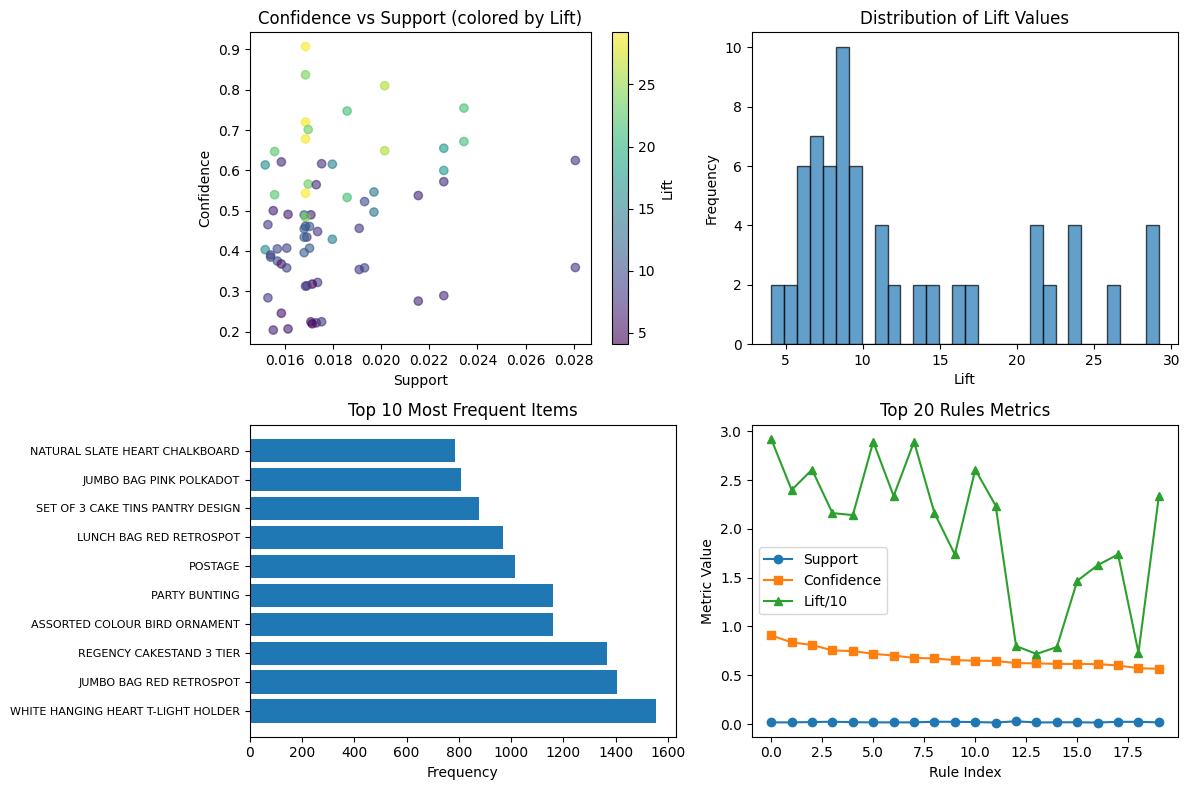

In [33]:
plt.figure(figsize=(12, 8))

# Plot 1: Confidence vs Support
plt.subplot(2, 2, 1)
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Confidence vs Support (colored by Lift)')
plt.colorbar(label='Lift')

# Plot 2: Lift distribution
plt.subplot(2, 2, 2)
plt.hist(rules['lift'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Distribution of Lift Values')

# Plot 3: Top items frequency
plt.subplot(2, 2, 3)
top_items = data['Itemname'].value_counts().head(10)
plt.barh(range(len(top_items)), top_items.values)
plt.yticks(range(len(top_items)), top_items.index, fontsize=8)
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Items')

# Plot 4: Rules metrics comparison
plt.subplot(2, 2, 4)
metrics_data = rules[['support', 'confidence', 'lift']].head(20)
x = range(len(metrics_data))
plt.plot(x, metrics_data['support'], label='Support', marker='o')
plt.plot(x, metrics_data['confidence'], label='Confidence', marker='s')
plt.plot(x, metrics_data['lift']/10, label='Lift/10', marker='^')
plt.xlabel('Rule Index')
plt.ylabel('Metric Value')
plt.title('Top 20 Rules Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
def save_market_basket_model_h5(filename='market_basket_model.h5'):
    """
    Save complete market basket analysis model in H5 format
    Following TensorFlow/Keras-like structure for ML model compatibility
    """
    
    with h5py.File(filename, 'w') as f:
        
        # ===== MODEL METADATA =====
        metadata_group = f.create_group('model_metadata')
        metadata_group.attrs['model_type'] = 'market_basket_analysis'
        metadata_group.attrs['algorithm'] = 'apriori_association_rules'
        metadata_group.attrs['created_at'] = datetime.now().isoformat()
        metadata_group.attrs['total_transactions'] = len(pivot_table)
        metadata_group.attrs['total_unique_items'] = len(valid_products)
        metadata_group.attrs['total_frequent_itemsets'] = len(frequent_itemsets)
        metadata_group.attrs['total_association_rules'] = len(rules)
        metadata_group.attrs['min_support_threshold'] = 0.015
        metadata_group.attrs['min_confidence_threshold'] = 0.2
        metadata_group.attrs['framework_version'] = 'mlxtend'
        
        # ===== FREQUENT ITEMSETS =====
        freq_group = f.create_group('frequent_itemsets')
        
        # Convert itemsets to string representation for storage
        itemsets_str = [str(list(itemset)) for itemset in frequent_itemsets['itemsets']]
        freq_group.create_dataset('itemsets', 
                                data=[s.encode('utf-8') for s in itemsets_str],
                                dtype=h5py.string_dtype(encoding='utf-8'))
        freq_group.create_dataset('support', data=frequent_itemsets['support'].values)
        freq_group.create_dataset('length', data=frequent_itemsets['length'].values)
        
        # ===== ASSOCIATION RULES =====
        rules_group = f.create_group('association_rules')
        
        # Convert frozensets to string for storage
        antecedents_str = [str(list(ant)) for ant in rules['antecedents']]
        consequents_str = [str(list(cons)) for cons in rules['consequents']]
        
        rules_group.create_dataset('antecedents',
                                 data=[s.encode('utf-8') for s in antecedents_str],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        rules_group.create_dataset('consequents',
                                 data=[s.encode('utf-8') for s in consequents_str],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        rules_group.create_dataset('support', data=rules['support'].values)
        rules_group.create_dataset('confidence', data=rules['confidence'].values)
        rules_group.create_dataset('lift', data=rules['lift'].values)
        rules_group.create_dataset('leverage', data=rules['leverage'].values)
        rules_group.create_dataset('conviction', data=rules['conviction'].values)
        
        # ===== CROSS-SELLING RULES =====
        cross_group = f.create_group('cross_selling_rules')
        if len(cross_selling_rules) > 0:
            cross_antecedents_str = [str(list(ant)) for ant in cross_selling_rules['antecedents']]
            cross_consequents_str = [str(list(cons)) for cons in cross_selling_rules['consequents']]
            
            cross_group.create_dataset('antecedents',
                                     data=[s.encode('utf-8') for s in cross_antecedents_str],
                                     dtype=h5py.string_dtype(encoding='utf-8'))
            cross_group.create_dataset('consequents',
                                     data=[s.encode('utf-8') for s in cross_consequents_str],
                                     dtype=h5py.string_dtype(encoding='utf-8'))
            cross_group.create_dataset('support', data=cross_selling_rules['support'].values)
            cross_group.create_dataset('confidence', data=cross_selling_rules['confidence'].values)
            cross_group.create_dataset('lift', data=cross_selling_rules['lift'].values)
        
        # ===== UPSELLING RULES =====
        up_group = f.create_group('upselling_rules')
        if len(upselling_rules) > 0:
            up_antecedents_str = [str(list(ant)) for ant in upselling_rules['antecedents']]
            up_consequents_str = [str(list(cons)) for cons in upselling_rules['consequents']]
            
            up_group.create_dataset('antecedents',
                                  data=[s.encode('utf-8') for s in up_antecedents_str],
                                  dtype=h5py.string_dtype(encoding='utf-8'))
            up_group.create_dataset('consequents',
                                  data=[s.encode('utf-8') for s in up_consequents_str],
                                  dtype=h5py.string_dtype(encoding='utf-8'))
            up_group.create_dataset('support', data=upselling_rules['support'].values)
            up_group.create_dataset('confidence', data=upselling_rules['confidence'].values)
            up_group.create_dataset('lift', data=upselling_rules['lift'].values)
        
        # ===== ITEM STATISTICS =====
        items_group = f.create_group('item_statistics')
        
        # Top items with their frequencies
        top_items_dict = data['Itemname'].value_counts().head(100).to_dict()
        item_names = list(top_items_dict.keys())
        item_counts = list(top_items_dict.values())
        
        items_group.create_dataset('item_names',
                                 data=[name.encode('utf-8') for name in item_names],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        items_group.create_dataset('item_frequencies', data=item_counts)
        
        # All unique items for reference
        all_items = list(valid_products)
        items_group.create_dataset('all_items',
                                 data=[item.encode('utf-8') for item in all_items],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        
        # ===== PIVOT TABLE STRUCTURE =====
        pivot_group = f.create_group('pivot_table_info')
        pivot_group.attrs['n_transactions'] = pivot_table.shape[0]
        pivot_group.attrs['n_items'] = pivot_table.shape[1]
        
        # Store column names (item names)
        pivot_columns = list(pivot_table.columns)
        pivot_group.create_dataset('column_names',
                                 data=[col.encode('utf-8') for col in pivot_columns],
                                 dtype=h5py.string_dtype(encoding='utf-8'))
        
        # ===== MODEL PERFORMANCE METRICS =====
        perf_group = f.create_group('performance_metrics')
        perf_group.attrs['avg_support'] = float(rules['support'].mean())
        perf_group.attrs['avg_confidence'] = float(rules['confidence'].mean())
        perf_group.attrs['avg_lift'] = float(rules['lift'].mean())
        perf_group.attrs['max_support'] = float(rules['support'].max())
        perf_group.attrs['max_confidence'] = float(rules['confidence'].max())
        perf_group.attrs['max_lift'] = float(rules['lift'].max())
        perf_group.attrs['min_support'] = float(rules['support'].min())
        perf_group.attrs['min_confidence'] = float(rules['confidence'].min())
        perf_group.attrs['min_lift'] = float(rules['lift'].min())

print("Function save_market_basket_model_h5 defined successfully!")

Function save_market_basket_model_h5 defined successfully!


In [35]:
# Save the model
print("=" * 50)
print("SAVING MODEL IN H5 FORMAT FOR BACKEND")
print("=" * 50)

save_market_basket_model_h5('market_basket_model.h5')
print("✓ Model berhasil disimpan dalam format H5: 'market_basket_model.h5'")

SAVING MODEL IN H5 FORMAT FOR BACKEND
✓ Model berhasil disimpan dalam format H5: 'market_basket_model.h5'


In [36]:
class H5MarketBasketRecommender:
    """
    Market Basket Recommender yang menggunakan model H5
    Kompatibel dengan arsitektur TensorFlow/Keras untuk ML pipeline
    """
    
    def __init__(self, h5_model_path):
        """Load model dari file H5"""
        self.model_path = h5_model_path
        self.load_model()
    
    def load_model(self):
        """Load semua komponen model dari H5 file"""
        with h5py.File(self.model_path, 'r') as f:
            
            # Load metadata
            self.metadata = dict(f['model_metadata'].attrs)
            
            # Load frequent itemsets
            if 'frequent_itemsets' in f:
                freq_group = f['frequent_itemsets']
                self.frequent_itemsets = {
                    'itemsets': [eval(s.decode('utf-8')) for s in freq_group['itemsets'][:]],
                    'support': freq_group['support'][:],
                    'length': freq_group['length'][:]
                }
            
            # Load association rules
            if 'association_rules' in f:
                rules_group = f['association_rules']
                self.association_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in rules_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in rules_group['consequents'][:]],
                    'support': rules_group['support'][:],
                    'confidence': rules_group['confidence'][:],
                    'lift': rules_group['lift'][:]
                }
            
            # Load cross-selling rules
            if 'cross_selling_rules' in f and len(f['cross_selling_rules'].keys()) > 0:
                cross_group = f['cross_selling_rules']
                self.cross_selling_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in cross_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in cross_group['consequents'][:]],
                    'support': cross_group['support'][:],
                    'confidence': cross_group['confidence'][:],
                    'lift': cross_group['lift'][:]
                }
            else:
                self.cross_selling_rules = None
            
            # Load upselling rules
            if 'upselling_rules' in f and len(f['upselling_rules'].keys()) > 0:
                up_group = f['upselling_rules']
                self.upselling_rules = {
                    'antecedents': [eval(s.decode('utf-8')) for s in up_group['antecedents'][:]],
                    'consequents': [eval(s.decode('utf-8')) for s in up_group['consequents'][:]],
                    'support': up_group['support'][:],
                    'confidence': up_group['confidence'][:],
                    'lift': up_group['lift'][:]
                }
            else:
                self.upselling_rules = None
            
            # Load item statistics
            if 'item_statistics' in f:
                items_group = f['item_statistics']
                self.item_names = [s.decode('utf-8') for s in items_group['item_names'][:]]
                self.item_frequencies = items_group['item_frequencies'][:]
                self.all_items = [s.decode('utf-8') for s in items_group['all_items'][:]]
            
            # Load performance metrics
            if 'performance_metrics' in f:
                self.performance_metrics = dict(f['performance_metrics'].attrs)
    
    def get_cross_selling_recommendations(self, item, top_n=5, min_confidence=0.3):
        """Dapatkan rekomendasi cross-selling untuk item tertentu"""
        if not self.cross_selling_rules:
            return []
        
        recommendations = []
        
        for i, antecedent in enumerate(self.cross_selling_rules['antecedents']):
            if item in antecedent and self.cross_selling_rules['confidence'][i] >= min_confidence:
                consequent = self.cross_selling_rules['consequents'][i]
                if len(consequent) == 1:  # Cross-selling: 1 -> 1
                    recommendations.append({
                        'recommended_item': consequent[0],
                        'confidence': float(self.cross_selling_rules['confidence'][i]),
                        'support': float(self.cross_selling_rules['support'][i]),
                        'lift': float(self.cross_selling_rules['lift'][i]),
                        'rule_strength': 'cross_selling'
                    })
        
        # Sort by confidence and return top N
        recommendations.sort(key=lambda x: x['confidence'], reverse=True)
        return recommendations[:top_n]
    
    def get_upselling_recommendations(self, item, top_n=5, min_confidence=0.25):
        """Dapatkan rekomendasi upselling untuk item tertentu"""
        if not self.upselling_rules:
            return []
        
        recommendations = []
        
        for i, antecedent in enumerate(self.upselling_rules['antecedents']):
            if item in antecedent and self.upselling_rules['confidence'][i] >= min_confidence:
                consequents = self.upselling_rules['consequents'][i]
                recommendations.append({
                    'recommended_items': consequents,
                    'confidence': float(self.upselling_rules['confidence'][i]),
                    'support': float(self.upselling_rules['support'][i]),
                    'lift': float(self.upselling_rules['lift'][i]),
                    'rule_strength': 'upselling',
                    'bundle_size': len(consequents)
                })
        
        # Sort by confidence and return top N
        recommendations.sort(key=lambda x: x['confidence'], reverse=True)
        return recommendations[:top_n]
    
    def get_basket_recommendations(self, basket_items, top_n=10, min_confidence=0.2):
        """Rekomendasi berdasarkan keranjang belanja saat ini"""
        all_recommendations = {}
        
        for item in basket_items:
            if item in self.all_items:
                # Get cross-selling recommendations
                cross_recs = self.get_cross_selling_recommendations(item, top_n=20, min_confidence=min_confidence)
                
                for rec in cross_recs:
                    rec_item = rec['recommended_item']
                    if rec_item not in basket_items:  # Jangan rekomendasikan item yang sudah ada
                        if rec_item not in all_recommendations:
                            all_recommendations[rec_item] = {
                                'total_confidence': 0,
                                'total_support': 0,
                                'total_lift': 0,
                                'rule_count': 0,
                                'supporting_items': []
                            }
                        
                        all_recommendations[rec_item]['total_confidence'] += rec['confidence']
                        all_recommendations[rec_item]['total_support'] += rec['support']
                        all_recommendations[rec_item]['total_lift'] += rec['lift']
                        all_recommendations[rec_item]['rule_count'] += 1
                        all_recommendations[rec_item]['supporting_items'].append(item)
        
        # Calculate averages and create final recommendations
        final_recommendations = []
        for item, stats in all_recommendations.items():
            if stats['rule_count'] > 0:
                final_recommendations.append({
                    'recommended_item': item,
                    'avg_confidence': stats['total_confidence'] / stats['rule_count'],
                    'avg_support': stats['total_support'] / stats['rule_count'],
                    'avg_lift': stats['total_lift'] / stats['rule_count'],
                    'supporting_rules': stats['rule_count'],
                    'supporting_items': stats['supporting_items']
                })
        
        # Sort by average confidence
        final_recommendations.sort(key=lambda x: x['avg_confidence'], reverse=True)
        return final_recommendations[:top_n]
    
    def get_model_info(self):
        """Informasi model dan performa"""
        return {
            'model_metadata': self.metadata,
            'performance_metrics': self.performance_metrics if hasattr(self, 'performance_metrics') else {},
            'total_items': len(self.all_items) if hasattr(self, 'all_items') else 0,
            'top_items': dict(zip(self.item_names[:10], self.item_frequencies[:10])) if hasattr(self, 'item_names') else {}
        }

print("H5MarketBasketRecommender class defined successfully!")

H5MarketBasketRecommender class defined successfully!


In [37]:
print("=" * 50)
print("TESTING H5 MODEL LOADER")
print("=" * 50)

# Initialize H5 recommender
h5_recommender = H5MarketBasketRecommender('market_basket_model.h5')

# Get model info
model_info = h5_recommender.get_model_info()
print("Model Information:")
print(f"- Total items: {model_info['total_items']}")
print(f"- Model created: {model_info['model_metadata']['created_at']}")
print(f"- Total rules: {model_info['model_metadata']['total_association_rules']}")

TESTING H5 MODEL LOADER
Model Information:
- Total items: 3529
- Model created: 2025-06-09T20:31:50.977340
- Total rules: 69


In [39]:
# Basket recommendations
if hasattr(h5_recommender, 'item_names') and len(h5_recommender.item_names) > 1:
    test_basket = [h5_recommender.item_names[0]]
    if len(h5_recommender.item_names) > 1:
        test_basket.append(h5_recommender.item_names[1])
    
    print(f"Testing dengan basket: {test_basket}")
    basket_recs = h5_recommender.get_basket_recommendations(test_basket, top_n=5)
    print(f"Basket recommendations:")
    for rec in basket_recs:
        print(f"  - {rec['recommended_item']} (Avg Confidence: {rec['avg_confidence']:.3f}, Rules: {rec['supporting_rules']})")

Testing dengan basket: ['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT']
Basket recommendations:
  - JUMBO BAG PINK POLKADOT (Avg Confidence: 0.359, Rules: 1)
  - JUMBO STORAGE BAG SUKI (Avg Confidence: 0.289, Rules: 1)
  - JUMBO SHOPPER VINTAGE RED PAISLEY (Avg Confidence: 0.276, Rules: 1)
  - JUMBO BAG STRAWBERRY (Avg Confidence: 0.224, Rules: 1)
  - JUMBO  BAG BAROQUE BLACK WHITE (Avg Confidence: 0.222, Rules: 1)
